**Part1: Grid detection: colours, cooridnates**

In [51]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import cv2

In [2]:
def plot_img(img, cmap = 'gray'):
    plt.figure(figsize=(18,10))
    plt.imshow(img, cmap=cmap)
    plt.axis('off')
    plt.show() 

Finding four points to warp the picture

In [5]:
def four_points(img):
  
  #red mask 
  HLS = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
  HUE = HLS[:, :, 0]             
  LIGHT = HLS[:, :, 1]
  SAT = HLS[:, :, 2]
  mask = (SAT > 65)  & (HUE > 112) 

  mask_int = mask.astype(np.uint8)
  kernel = np.ones((20,20))
  mask_int = cv2.morphologyEx(mask_int, cv2.MORPH_CLOSE, kernel)
  kernel = np.ones((13,13))
  mask_int = cv2.morphologyEx(mask_int, cv2.MORPH_OPEN, kernel)
  contours, hierarchy = cv2.findContours(mask_int, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

  areas = []

  for i in range(len(contours)):
      area = cv2.contourArea(contours[i])
      if area > 1500:
        areas.append(i)

  for i in range(len(areas)):
    cv2.drawContours(mask_int,[contours[areas[i]]],-1,(255,255,255),2)

  #finding four corner points

  points = []
  for i in range(mask_int.shape[0]):
    for j in range(mask_int.shape[1]):
      if mask_int[i][j] == 1:
        points.append([j, i])
  points = sorted(points)      
  left_x_up = points[0][0]
  left_y_up = points[0][1]
  right_x_bottom = points[-1][0]
  right_y_bottom = points[-1][1]
  left_x_bottom = left_x_up
  left_y_bottom = right_y_bottom
  right_x_up = right_x_bottom
  right_y_up = left_y_up
  
  #cv2.circle(img, (left_x_up, left_y_up), 5, (255 , 0, 0), -1)
  #cv2.circle(img, (right_x_up-10, right_y_up-20), 5, (255 , 0, 0), -1)
  #cv2.circle(img, (left_x_bottom+10, left_y_bottom+15), 5, (255 , 0, 0), -1)
  #cv2.circle(img, (right_x_bottom, right_y_bottom+5), 5, (255 , 0, 0), -1)
  
  pt_A = [left_x_up, left_y_up]
  pt_B = [left_x_bottom+10, left_y_bottom+15]
  pt_C = [right_x_bottom, right_y_bottom+5]
  pt_D = [right_x_up-10, right_y_up-20]

  #plot_img(mask_int)
  plot_img(img[..., ::-1]) 
  
  return pt_A, pt_B, pt_C, pt_D

Function that warps the picture

In [6]:
# https://theailearner.com/tag/cv2-getperspectivetransform/

def change_perspective(pt_A, pt_B, pt_C, pt_D):
  
  width_AD = np.sqrt(((pt_A[0] - pt_D[0]) ** 2) + ((pt_A[1] - pt_D[1]) ** 2))
  width_BC = np.sqrt(((pt_B[0] - pt_C[0]) ** 2) + ((pt_B[1] - pt_C[1]) ** 2))
  maxWidth = max(int(width_AD), int(width_BC))


  height_AB = np.sqrt(((pt_A[0] - pt_B[0]) ** 2) + ((pt_A[1] - pt_B[1]) ** 2))
  height_CD = np.sqrt(((pt_C[0] - pt_D[0]) ** 2) + ((pt_C[1] - pt_D[1]) ** 2))
  maxHeight = max(int(height_AB), int(height_CD))


  width_AD = np.sqrt(((pt_A[0] - pt_D[0]) ** 2) + ((pt_A[1] - pt_D[1]) ** 2))
  width_BC = np.sqrt(((pt_B[0] - pt_C[0]) ** 2) + ((pt_B[1] - pt_C[1]) ** 2))
  maxWidth = max(int(width_AD), int(width_BC))
 
 
  height_AB = np.sqrt(((pt_A[0] - pt_B[0]) ** 2) + ((pt_A[1] - pt_B[1]) ** 2))
  height_CD = np.sqrt(((pt_C[0] - pt_D[0]) ** 2) + ((pt_C[1] - pt_D[1]) ** 2))
  maxHeight = max(int(height_AB), int(height_CD))


  input_pts = np.float32([pt_A, pt_B, pt_C, pt_D])
  output_pts = np.float32([[0, 0],
                          [0, maxHeight - 1],
                          [maxWidth - 1, maxHeight - 1],
                          [maxWidth - 1, 0]])

  input_pts = np.float32([pt_A, pt_B, pt_C, pt_D])
  output_pts = np.float32([[0, 0],
                          [0, maxHeight - 1],
                          [maxWidth - 1, maxHeight - 1],
                          [maxWidth - 1, 0]])
  
  M = cv2.getPerspectiveTransform(input_pts,output_pts)

  out = cv2.warpPerspective(img,M,(maxWidth, maxHeight),flags=cv2.INTER_LINEAR)

  return out

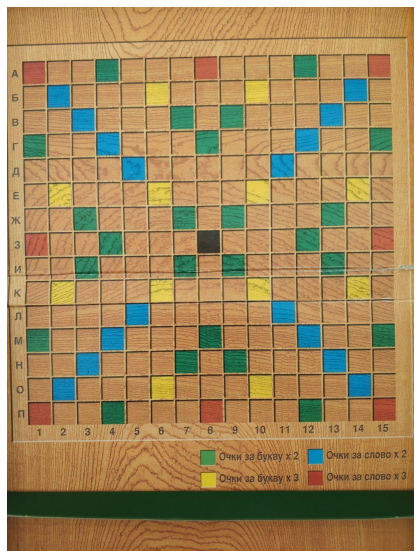

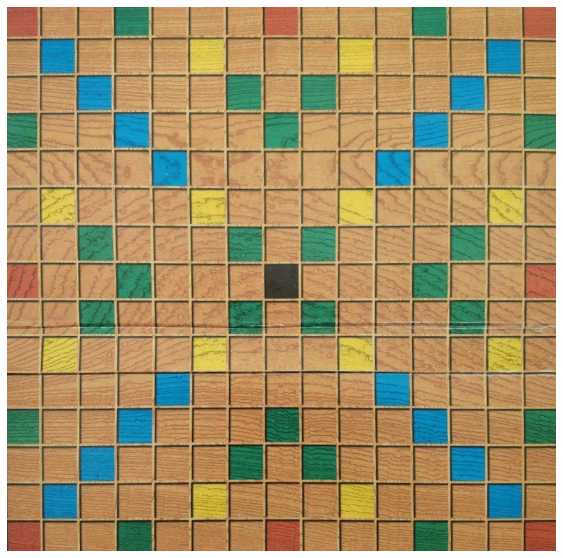

In [7]:
img = cv2.imread("./board3.jpg")
pt_A, pt_B, pt_C, pt_D = four_points(img)
warped = change_perspective(pt_A, pt_B, pt_C, pt_D)
plot_img(warped[..., ::-1]) 

Board cells coordinates detection

In [11]:
from PIL import Image  

In [8]:
def change_list(list1):
  new_list = []
  for elem in list1:
    new_list.append([elem[0], elem[1]+58])
  return new_list

In [14]:
def board_grid(warped):
  
  center_x = 20
  center_y = 20
  first_row = [[center_x, center_y]]

  cv2.circle(warped, (20, 20), 5, (255 , 0, 0), -1)

  #first row creation
  for j in range(2, 16):
    center_y = center_y +58
    cv2.circle(warped, (center_y, center_x), 5, (255,0, 0), -1)
    cv2.circle(warped, (center_y, center_x), 5, (255,0, 0), -1)
    first_row.append([center_y, center_x])

  #iteration over the remaining rows]

  rows = [first_row]
  for j in range(15):
    curr_row = rows[-1].copy()
    new_row = change_list(curr_row)
    rows.append(new_row)
    for elem in curr_row:
      cv2.circle(warped, (elem[0], elem[1]), 5, (255,0, 0), -1)
  im = Image.fromarray(warped[..., ::-1])
  im.save("board_dots.jpg")  
  plot_img(warped[..., ::-1]) 
  return rows

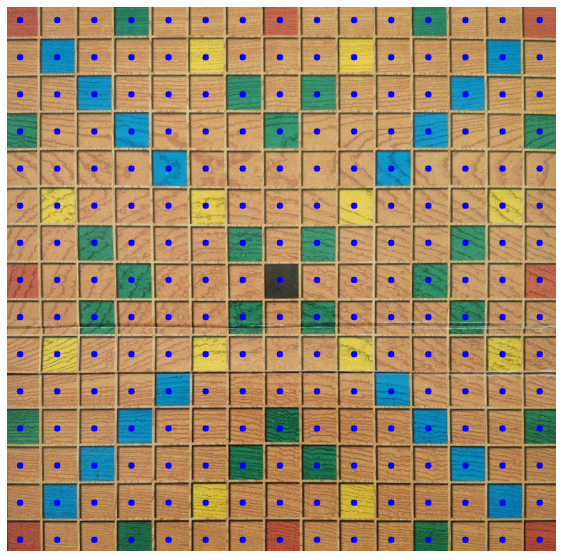

In [15]:
grid_coords = board_grid(warped)

Masks

In [33]:
def red_mask(warped):

  HLS = cv2.cvtColor(warped, cv2.COLOR_RGB2HLS)
  HUE = HLS[:, :, 0]             
  LIGHT = HLS[:, :, 1]
  SAT = HLS[:, :, 2]
  mask = (SAT > 65)  & (HUE > 112) 

  mask_int = mask.astype(np.uint8)
  kernel = np.ones((20,20))
  mask_int = cv2.morphologyEx(mask_int, cv2.MORPH_CLOSE, kernel)
  kernel = np.ones((13,13))
  mask_int = cv2.morphologyEx(mask_int, cv2.MORPH_OPEN, kernel)
  contours, hierarchy = cv2.findContours(mask_int, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

  for i in range(len(contours)):
    cv2.drawContours(mask_int,[contours[i]],-1,(255,255,255),-1)

  red_mask_coords = []
  for j in range(len(contours)):
    M = cv2.moments(contours[j])
    cx = int(M['m10']/M['m00'])
    cy = int(M['m01']/M['m00'])
    cv2.circle(mask_int, (cx, cy), 5, (255,0,0), -1)
    red_mask_coords.append([cx, cy])
  
  im = Image.fromarray(mask_int[..., ::-1])
  im.save("red_mask.jpg")  

  plot_img(mask_int[..., ::-1]) 

  return red_mask_coords

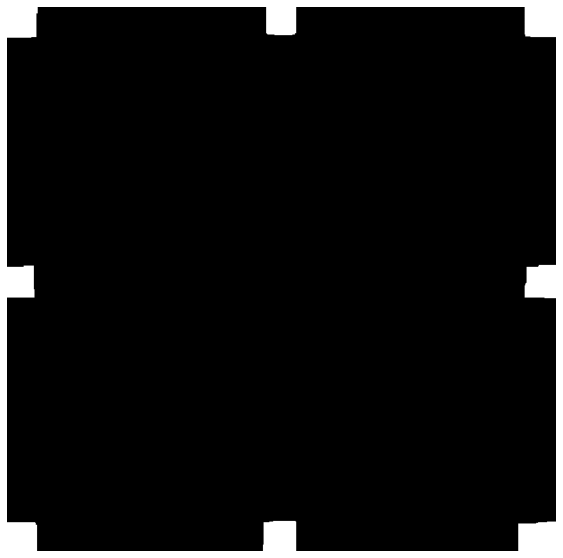

In [34]:
red_coords = red_mask(warped)

In [35]:
def green_mask(warped):

  hsv = cv2.cvtColor(warped, cv2.COLOR_BGR2HSV)

  lower_red = np.array([53,10,30])

  upper_red = np.array([93,255,255])

  mask = cv2.inRange(hsv, lower_red, upper_red)


  mask_int = mask.astype(np.uint8)
  kernel = np.ones((17,17))
  mask_int = cv2.morphologyEx(mask_int, cv2.MORPH_CLOSE, kernel)
  kernel = np.ones((5,5))
  mask_int = cv2.morphologyEx(mask_int, cv2.MORPH_OPEN, kernel)
  contours, hierarchy = cv2.findContours(mask_int, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

  green_mask_coords = []
  for j in range(len(contours)):
    M = cv2.moments(contours[j])
    cx = int(M['m10']/M['m00'])
    cy = int(M['m01']/M['m00'])
    cv2.circle(mask_int, (cx, cy), 5, (255,0,0), -1)
    green_mask_coords.append([cx, cy])

  im = Image.fromarray(mask_int[..., ::-1])
  im.save("green_mask.jpg")  

  plot_img(mask_int[..., ::-1]) 

  return green_mask_coords

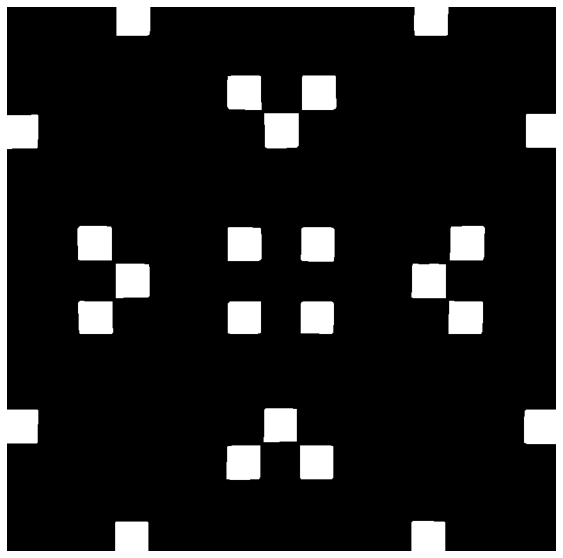

In [36]:
green_coords = green_mask(warped)

In [37]:
def blue_mask(warped):

  hsv = cv2.cvtColor(warped, cv2.COLOR_BGR2HSV)

  lower_red = np.array([82,50,50])

  upper_red = np.array([130,255,255])

  mask = cv2.inRange(hsv, lower_red, upper_red)

  mask_int = mask.astype(np.uint8)
  kernel = np.ones((17,17))
  mask_int = cv2.morphologyEx(mask_int, cv2.MORPH_CLOSE, kernel)
  kernel = np.ones((30,30))
  mask_int = cv2.morphologyEx(mask_int, cv2.MORPH_OPEN, kernel)
  contours, hierarchy = cv2.findContours(mask_int, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)


  blue_mask_coords = []
  for j in range(len(contours)):
    M = cv2.moments(contours[j])
    cx = int(M['m10']/M['m00'])
    cy = int(M['m01']/M['m00'])
    cv2.circle(mask_int, (cx, cy), 5, (255,0,0), -1)
    blue_mask_coords.append([cx, cy])
    
  im = Image.fromarray(mask_int[..., ::-1])
  im.save("blue_mask.jpg") 

  plot_img(mask_int[..., ::-1]) 

  return blue_mask_coords

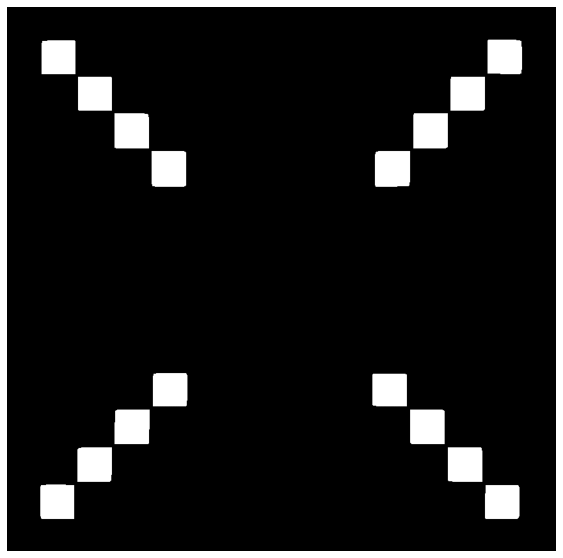

In [38]:
blue_coords = blue_mask(warped)

In [39]:
def yellow_mask(warped):

  hsv = cv2.cvtColor(warped, cv2.COLOR_BGR2HSV)

  lower_red = np.array([25,100,100])
  upper_red = np.array([26,250,250])

  mask = cv2.inRange(hsv, lower_red, upper_red)

  mask_int = mask.astype(np.uint8)
  kernel = np.ones((20,20))
  mask_int = cv2.morphologyEx(mask_int, cv2.MORPH_CLOSE, kernel)
  kernel = np.ones((23,23))
  mask_int = cv2.morphologyEx(mask_int, cv2.MORPH_OPEN, kernel)
  contours, hierarchy = cv2.findContours(mask_int, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)


  yellow_mask_coords = []
  for j in range(len(contours)):
    M = cv2.moments(contours[j])
    cx = int(M['m10']/M['m00'])
    cy = int(M['m01']/M['m00'])
    cv2.circle(mask_int, (cx, cy), 5, (255,0,0), -1)
    yellow_mask_coords.append([cx, cy])

  im = Image.fromarray(mask_int[..., ::-1])
  im.save("yellow_mask.jpg") 

  plot_img(mask_int[..., ::-1]) 

  return yellow_mask_coords

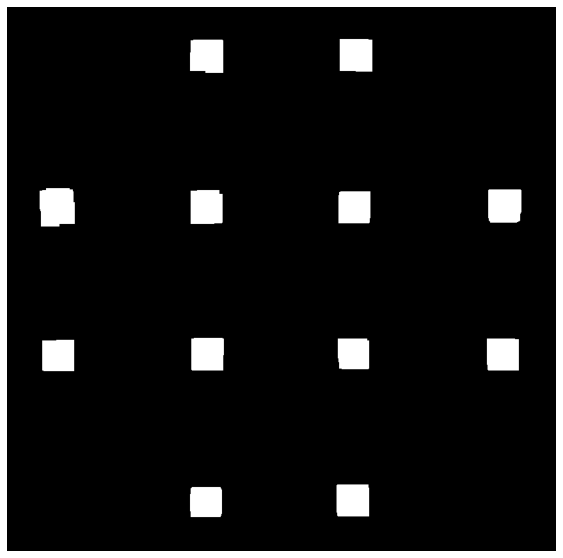

In [40]:
yellow_coords = yellow_mask(warped)

In [41]:
def black_mask(warped):

  HLS = cv2.cvtColor(warped, cv2.COLOR_RGB2HLS)
  HUE = HLS[:, :, 0]             
  LIGHT = HLS[:, :, 1]
  SAT = HLS[:, :, 2]
  mask = (SAT < 70) & (LIGHT < 70) 

  mask_int = mask.astype(np.uint8)
  kernel = np.ones((7,7))
  mask_int = cv2.morphologyEx(mask_int, cv2.MORPH_CLOSE, kernel)
  kernel = np.ones((7,7))
  mask_int = cv2.morphologyEx(mask_int, cv2.MORPH_OPEN, kernel)
  contours, hierarchy = cv2.findContours(mask_int, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  for i in range(len(contours)):
    cv2.drawContours(mask_int,[contours[i]],-1,(255,255,255),-1)

  black_mask_coords = []
  for j in range(len(contours)):
    M = cv2.moments(contours[j])
    cx = int(M['m10']/M['m00'])
    cy = int(M['m01']/M['m00'])
    cv2.circle(mask_int, (cx, cy), 5, (255,0,0), -1)
    black_mask_coords.append([cx, cy])

  im = Image.fromarray(mask_int[..., ::-1])
  im.save("black_mask.jpg") 

  plot_img(mask_int[..., ::-1]) 

  return black_mask_coords

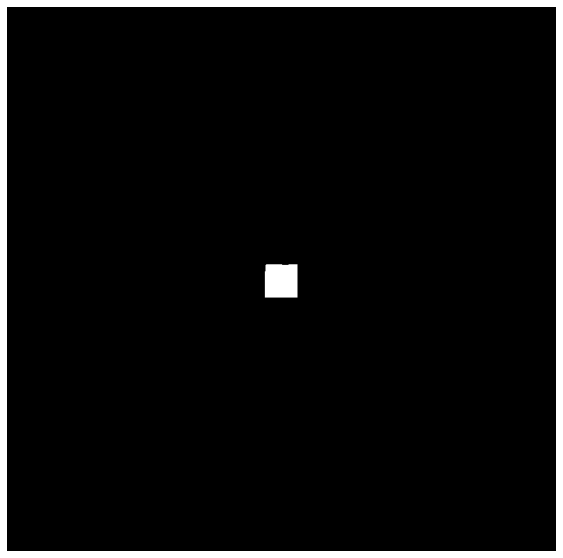

In [42]:
black_coords = black_mask(warped)

Board colours print

In [31]:
from scipy.spatial import distance

def board_colours(grid_coords, red_coords, green_coords, yellow_coords, black_coords):

  board = [[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], 
           [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], 
           [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], 
           [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], 
           [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], 
           [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], 
           [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], 
           [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], 
           [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], 
           [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], 
           [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], 
           [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], 
           [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], 
           [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], 
           [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]]

  #red mask
  for k in range(len(red_coords)):
    for i in range(len(grid_coords)):
      for j in range(len(grid_coords[0])):
        a = (grid_coords[i][j][0], grid_coords[i][j][1])
        b = (red_coords[k][0], red_coords[k][1])
        dst = distance.euclidean(a, b)
        if dst < 10:
          board[i][j] = 'red'

  #green mask
  for k in range(len(green_coords)):
    for i in range(len(grid_coords)):
      for j in range(len(grid_coords[0])):
        a = (grid_coords[i][j][0], grid_coords[i][j][1])
        b = (green_coords[k][0], green_coords[k][1])
        dst = distance.euclidean(a, b)
        if dst < 10:
          board[i][j] = 'green'

  #blue mask
  for k in range(len(blue_coords)):
    for i in range(len(grid_coords)):
      for j in range(len(grid_coords[0])):
        a = (grid_coords[i][j][0], grid_coords[i][j][1])
        b = (blue_coords[k][0], blue_coords[k][1])
        dst = distance.euclidean(a, b)
        if dst < 10:
          board[i][j] = 'blue'
  
  #yellow mask
  for k in range(len(yellow_coords)):
    for i in range(len(grid_coords)):
      for j in range(len(grid_coords[0])):
        a = (grid_coords[i][j][0], grid_coords[i][j][1])
        b = (yellow_coords[k][0], yellow_coords[k][1])
        dst = distance.euclidean(a, b)
        if dst < 10:
          board[i][j] = 'yellow'

  #black mask

  for k in range(len(black_coords)):
    for i in range(len(grid_coords)):
      for j in range(len(grid_coords[0])):
        a = (grid_coords[i][j][0], grid_coords[i][j][1])
        b = (black_coords[k][0], black_coords[k][1])
        dst = distance.euclidean(a, b)
        if dst < 10:
          board[i][j] = 'black'

  return board

In [32]:
board = board_colours(grid_coords, red_coords, green_coords, yellow_coords, black_coords)
board

[['red', 0, 0, 'green', 0, 0, 0, 'red', 0, 0, 0, 'green', 0, 0, 'red'],
 [0, 'blue', 0, 0, 0, 'yellow', 0, 0, 0, 'yellow', 0, 0, 0, 'blue', 0],
 [0, 0, 'blue', 0, 0, 0, 'green', 0, 'green', 0, 0, 0, 'blue', 0, 0],
 ['green', 0, 0, 'blue', 0, 0, 0, 'green', 0, 0, 0, 'blue', 0, 0, 'green'],
 [0, 0, 0, 0, 'blue', 0, 0, 0, 0, 0, 'blue', 0, 0, 0, 0],
 [0, 'yellow', 0, 0, 0, 'yellow', 0, 0, 0, 'yellow', 0, 0, 0, 'yellow', 0],
 [0, 0, 'green', 0, 0, 0, 'green', 0, 'green', 0, 0, 0, 'green', 0, 0],
 ['red', 0, 0, 'green', 0, 0, 0, 'black', 0, 0, 0, 'green', 0, 0, 'red'],
 [0, 0, 'green', 0, 0, 0, 'green', 0, 'green', 0, 0, 0, 'green', 0, 0],
 [0, 'yellow', 0, 0, 0, 'yellow', 0, 0, 0, 'yellow', 0, 0, 0, 'yellow', 0],
 [0, 0, 0, 0, 'blue', 0, 0, 0, 0, 0, 'blue', 0, 0, 0, 0],
 ['green', 0, 0, 'blue', 0, 0, 0, 'green', 0, 0, 0, 'blue', 0, 0, 'green'],
 [0, 0, 'blue', 0, 0, 0, 'green', 0, 'green', 0, 0, 0, 'blue', 0, 0],
 [0, 'blue', 0, 0, 0, 'yellow', 0, 0, 0, 'yellow', 0, 0, 0, 'blue', 0],
 ['red

**Part2: Letters detection**

In [56]:
def four_points(img):
  
  #red mask 
  HLS = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
  HUE = HLS[:, :, 0]             
  LIGHT = HLS[:, :, 1]
  SAT = HLS[:, :, 2]
  mask = (SAT > 65)  & (HUE > 112) 

  mask_int = mask.astype(np.uint8)
  kernel = np.ones((20,20))
  mask_int = cv2.morphologyEx(mask_int, cv2.MORPH_CLOSE, kernel)
  kernel = np.ones((13,13))
  mask_int = cv2.morphologyEx(mask_int, cv2.MORPH_OPEN, kernel)
  contours, hierarchy = cv2.findContours(mask_int, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

  areas = []

  for i in range(len(contours)):
      area = cv2.contourArea(contours[i])
      if area > 1500:
        areas.append(i)

  for i in range(len(areas)):
    cv2.drawContours(mask_int,[contours[areas[i]]],-1,(255,255,255),2)

  #finding four corner points

  points = []
  for i in range(mask_int.shape[0]):
    for j in range(mask_int.shape[1]):
      if mask_int[i][j] == 1:
        points.append([j, i])
  points = sorted(points)      
  left_x_up = points[0][0]
  left_y_up = points[0][1]
  right_x_bottom = points[-1][0]
  right_y_bottom = points[-1][1]
  left_x_bottom = left_x_up
  left_y_bottom = right_y_bottom
  right_x_up = right_x_bottom
  right_y_up = left_y_up
  
  #cv2.circle(img, (left_x_up, left_y_up), 5, (255 , 0, 0), -1)
  #cv2.circle(img, (right_x_up-10, right_y_up-20), 5, (255 , 0, 0), -1)
  #cv2.circle(img, (left_x_bottom+10, left_y_bottom+15), 5, (255 , 0, 0), -1)
  #cv2.circle(img, (right_x_bottom, right_y_bottom+5), 5, (255 , 0, 0), -1)
  
  pt_A = [left_x_up, left_y_up]
  pt_B = [left_x_bottom+20, left_y_bottom+25]
  pt_C = [right_x_bottom, right_y_bottom+5]
  pt_D = [right_x_up-20, right_y_up-30]

  plot_img(mask_int)
  #plot_img(img[..., ::-1]) 
  
  return pt_A, pt_B, pt_C, pt_D

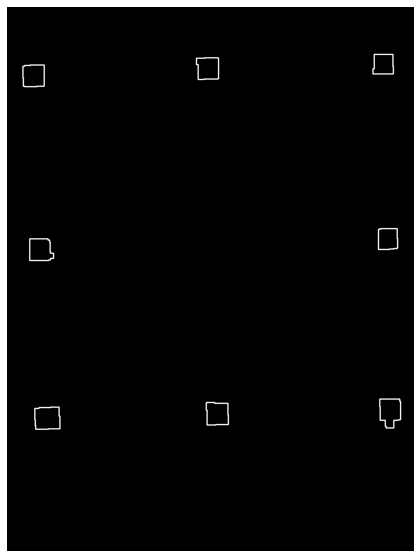

In [61]:
img = cv2.imread("./train2.jpg")
pt_A, pt_B, pt_C, pt_D = four_points(img)
warped = change_perspective(pt_A, pt_B, pt_C, pt_D)

Letters detection

22


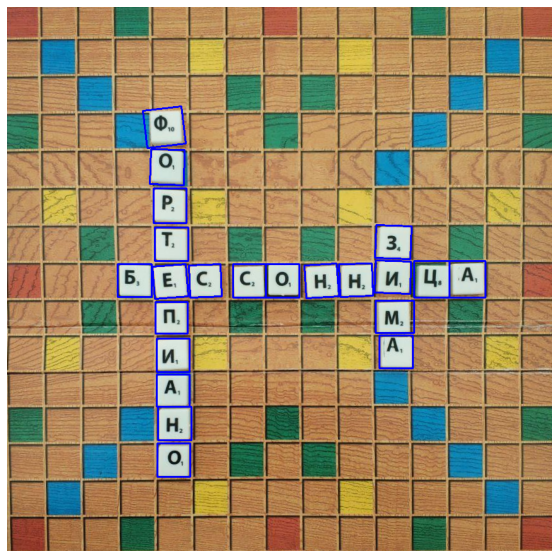

In [62]:
import cv2
hsv_min = np.array((0, 54, 5), np.uint8)
hsv_max = np.array((187, 255, 253), np.uint8)

hsv = cv2.cvtColor(warped, cv2.COLOR_BGR2HSV ) # меняем цветовую модель с BGR на HSV
thresh = cv2.inRange( hsv, hsv_min, hsv_max ) # применяем цветовой фильтр
contours0, hierarchy = cv2.findContours(thresh.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

amount = 0
boxes = []
boxes_coords = []

for cnt in contours0:
    rect = cv2.minAreaRect(cnt) # пытаемся вписать прямоугольник
    box = cv2.boxPoints(rect) # поиск четырех вершин прямоугольника
    box = np.int0(box) # округление координат
    area = cv2.contourArea(cnt)
    if area > 1500 and area < 3000:
      boxes.append(box)
      M = cv2.moments(cnt)
      cx = int(M['m10']/M['m00'])
      cy = int(M['m01']/M['m00'])
      boxes_coords.append([cx, cy])
      amount += 1
      cv2.drawContours(warped,[box],0,(255,0,0),2) # 
    if area > 3000 and area < 10000:
      lux = box[0][0]
      luy = box[0][1]
      rux = box[1][0]
      ruy = box[1][1]
      ldx = box[2][0]
      ldy = box[2][1]
      rdx = box[3][0]
      rdy = box[3][1]
      min_x = min(lux, rux, ldx, rdx)
      max_x = max(lux, rux, ldx, rdx)
      min_y = min(luy, ruy, ldy, rdy)
      max_y = max(luy, ruy, ldy, rdy)
      mean_x = (max_x-min_x)//2+min_x
      mean_y = (max_y-min_y)//2+min_y

      box2 = [[min_x, min_y],  [mean_x, min_y], [mean_x, max_y], [min_x, max_y]]
      box2 = np.int0(box2)
      boxes.append(box2)
      #cv2.circle(warped, (mean_x+25, mean_y), 5, (255,0, 0), -1)
  
      amount += 1
      cv2.drawContours(warped,[box2],0,(255,0,0),2)

      box1 = [[max_x, min_y],  [mean_x, min_y], [mean_x, max_y], [max_x, max_y]]
      box1 = np.int0(box1)
      boxes.append(box1)
      #cv2.circle(warped, (mean_x-25, mean_y), 5, (255,0, 0), -1)
    
      amount += 1
      cv2.drawContours(warped,[box1],0,(255,0,0),2)

      boxes_coords.append([mean_x-25, mean_y])
      boxes_coords.append([mean_x+25, mean_y])
  
print(amount)

im = Image.fromarray(warped[..., ::-1])
im.save("letters_detection.jpg") 

plot_img(warped[..., ::-1]) 

Coordinates all together

In [63]:
pics = []

for elem in boxes:
  
  lux = elem[0][0]
  luy = elem[0][1]
  rux = elem[1][0]
  ruy = elem[1][1]
  ldx = elem[2][0]
  ldy = elem[2][1]
  rdx = elem[3][0]
  rdy = elem[3][1]

  min_x = min(lux, rux, ldx, rdx)
  max_x = max(lux, rux, ldx, rdx)
  min_y = min(luy, ruy, ldy, rdy)
  max_y = max(luy, ruy, ldy, rdy)
  
  pic = warped[min_y+7:max_y-5, min_x+5:max_x-5]
  pics.append(pic)

Letters detection

Neuroset

In [68]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Flatten, Dense, Dropout
import sys
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [65]:
img_width, img_height = 28, 28
input_shape = (img_width, img_height,3)
num_classes = 33

In [66]:
model = Sequential()
model.add(Conv2D(30, kernel_size=(5, 5), activation='relu', input_shape=input_shape))
model.add(Conv2D(30, (5, 5), activation='relu'))
model.add(Conv2D(30, (5, 5), activation='relu'))
model.add(Conv2D(30, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))

In [67]:
model.load_weights("cyrrilic.h5" )

In [69]:
def predict_letter(template):
  
  im = Image.fromarray(template)
  im.save("template.jpg")
  img = Image.open('template.jpg')
  img = img.resize((28,28))
  arr = np.array(img) * 1./255
  arr = np.expand_dims(arr, axis=0)
  prediction = model.predict(arr)
  ma = {
    1:'А',    2:'Б',    3:'В',    4:'Г',
    5:'Д',    6:'Е',    7:'Ж',    8:'З',
    9:'И',    10:'И',    11:'К',    12:'Л',
    13:'М',    14:'Н',    15:'О',    16:'П',
    17:'Р',    18:'С',    19:'Т',    20:'У',
    21:'Ф',    22:'Х',    23:'Ц',    24:'Ч',
    25:'Ш',    26:'Щ',    27:'Ъ',    28:'Ы',
    29:'Ь',    30:'Э',    31:'Ю',    32:'Я'
     }
     
  pred = ma[prediction.argmax(axis=-1)[0]]
  certainty = round(max(prediction[0]) * 100,2)

  return pred

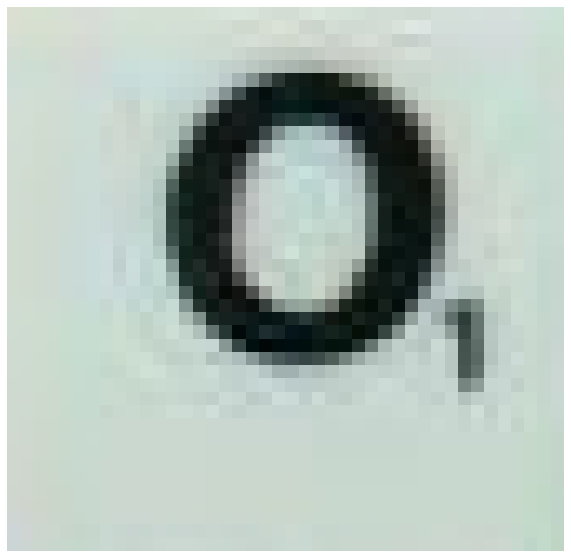

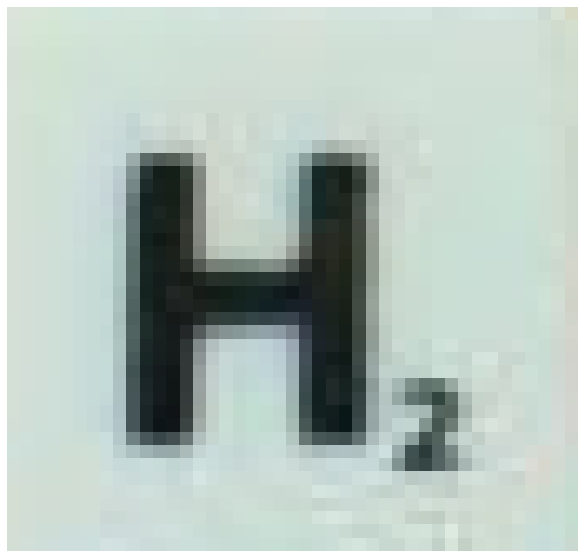

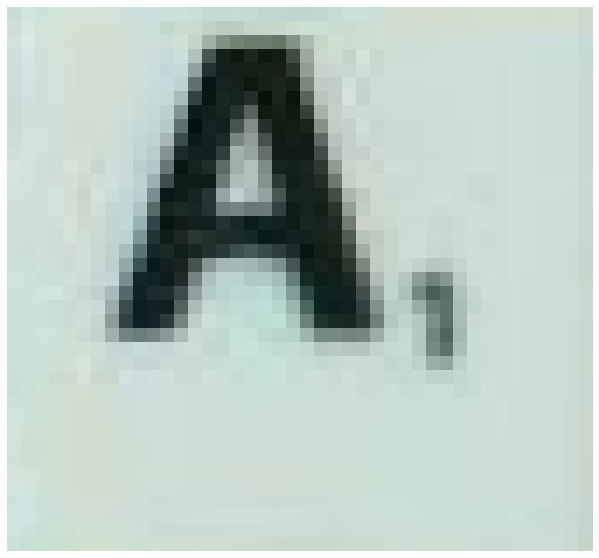

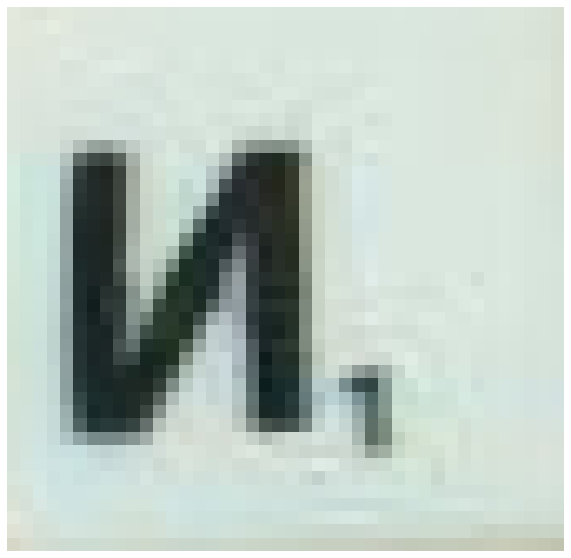

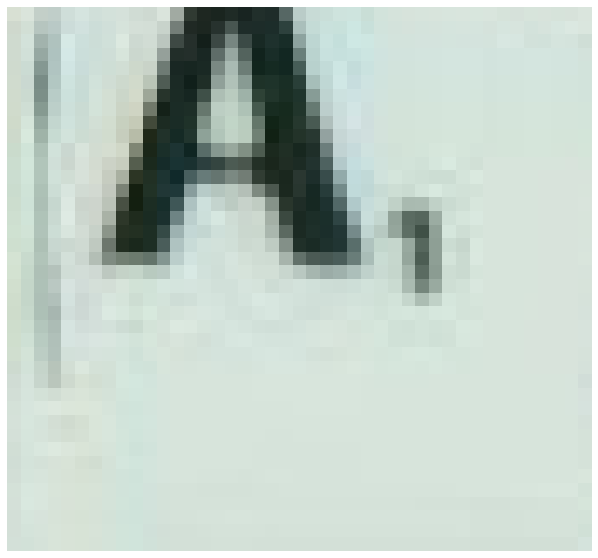

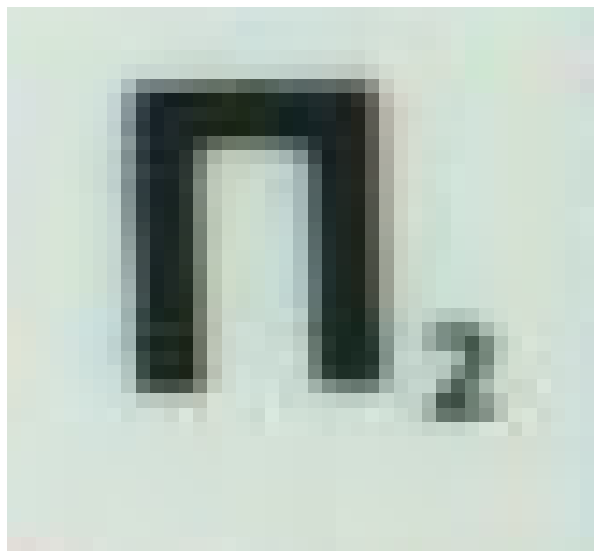

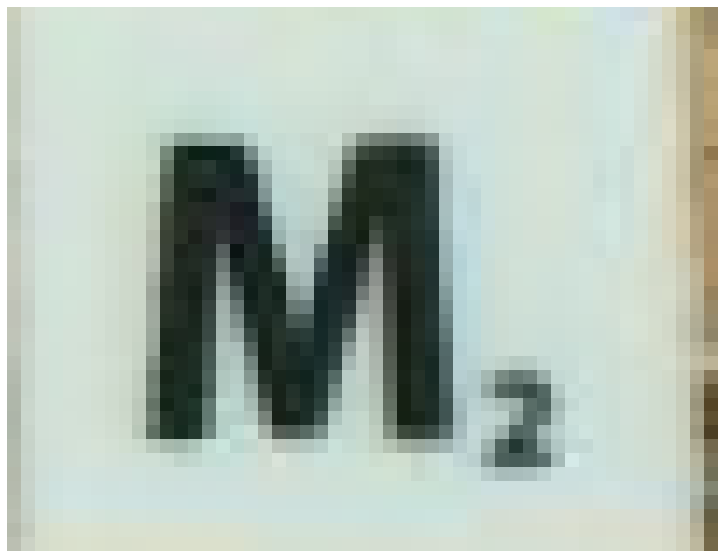

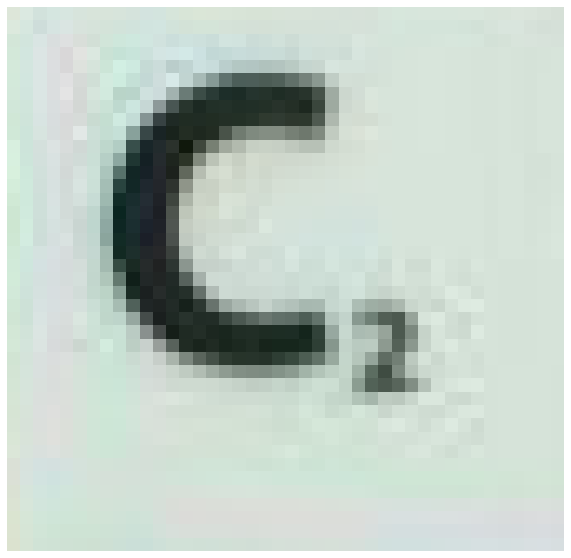

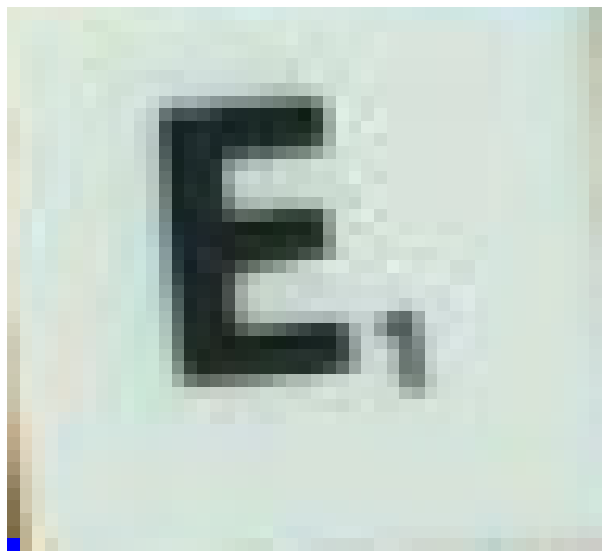

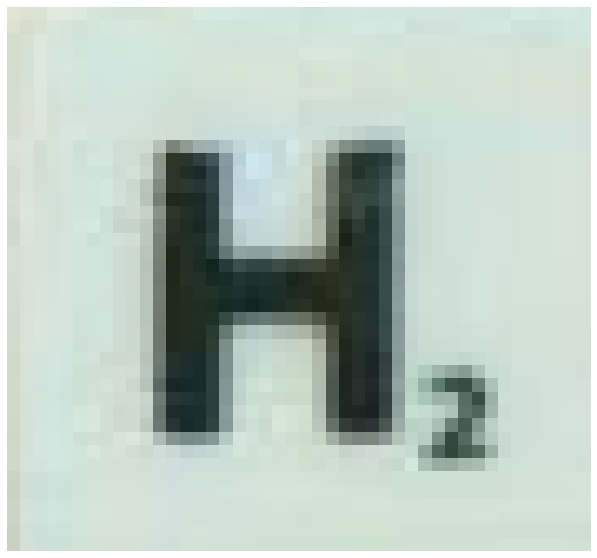

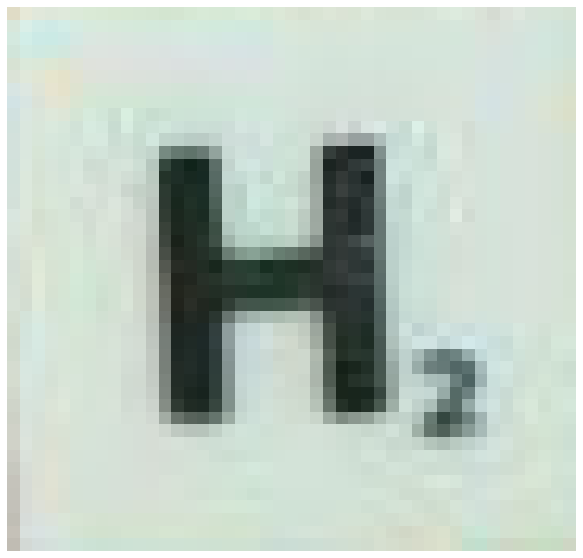

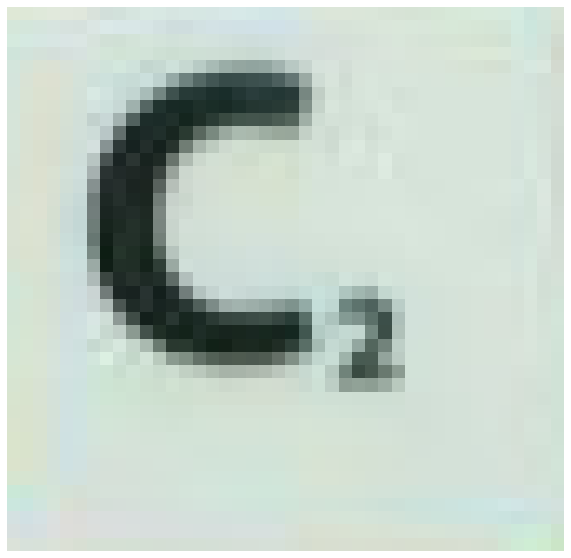

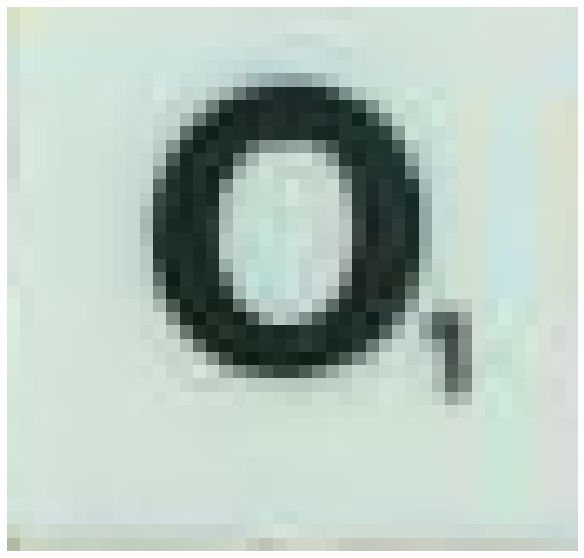

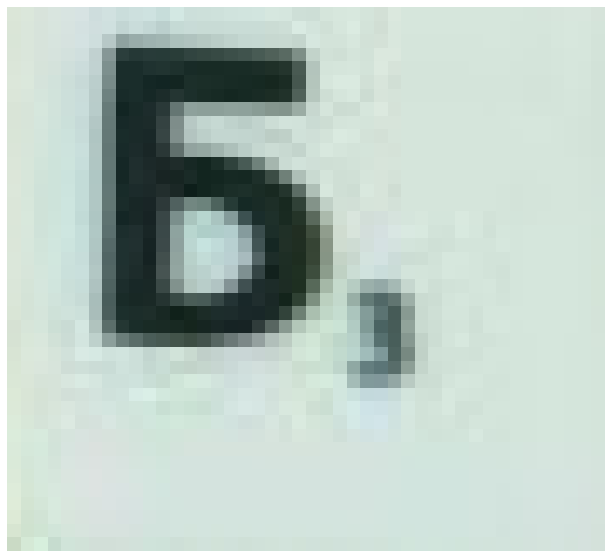

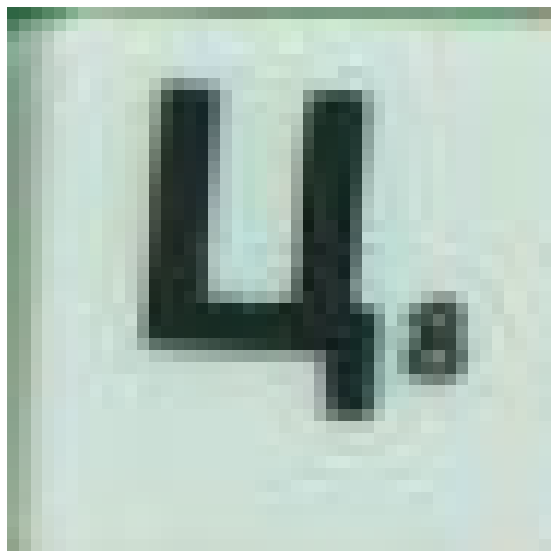

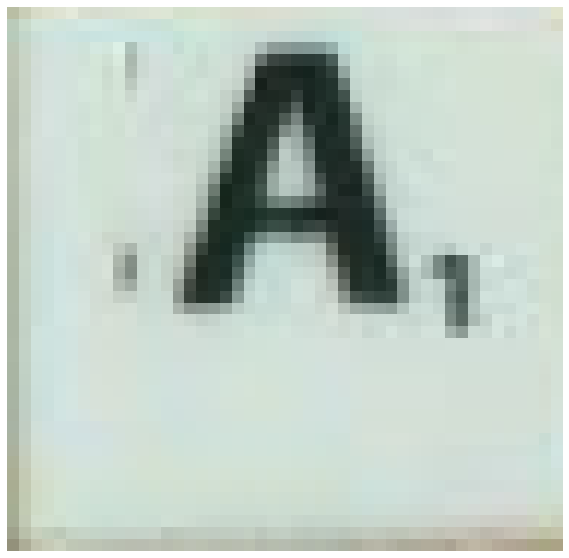

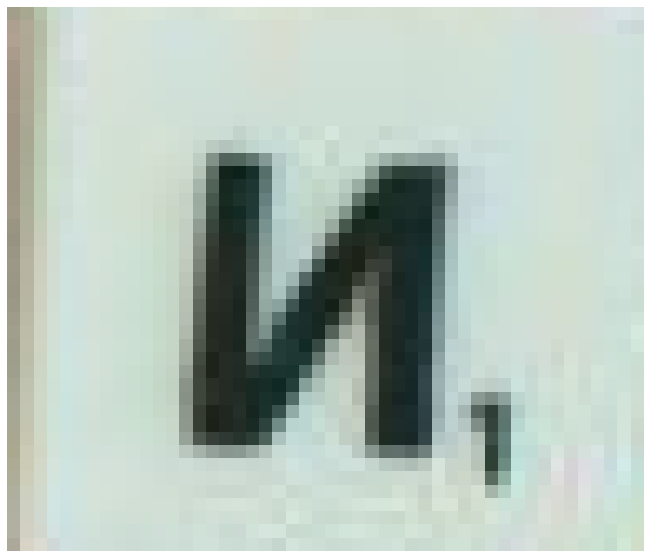

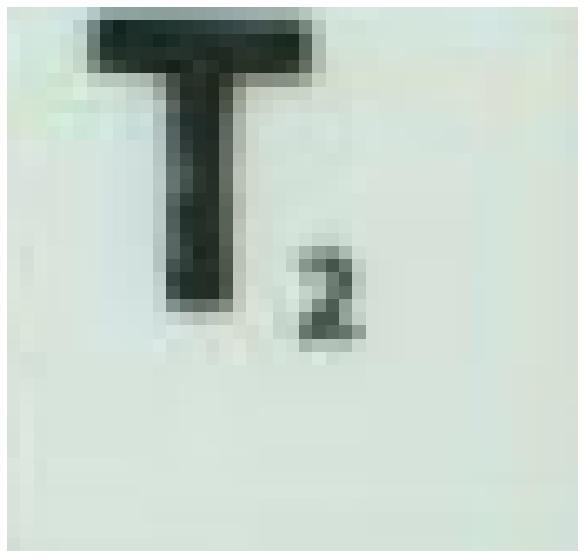

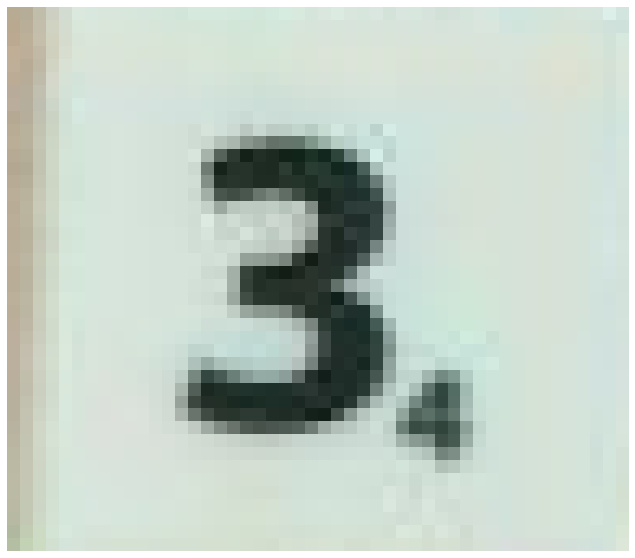

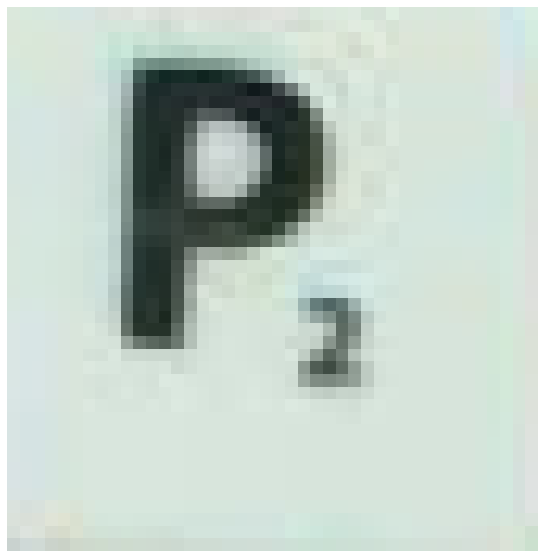

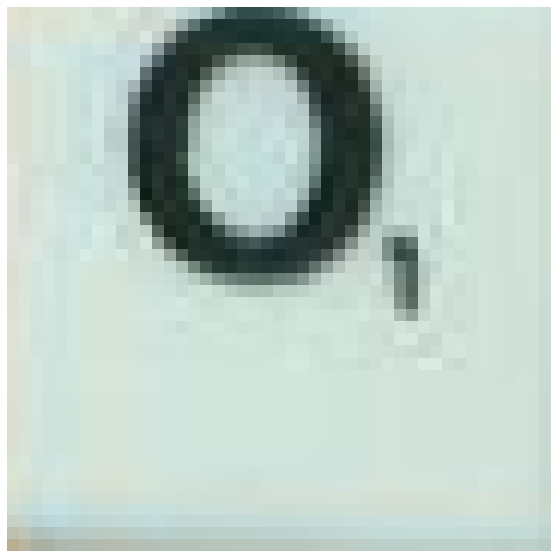

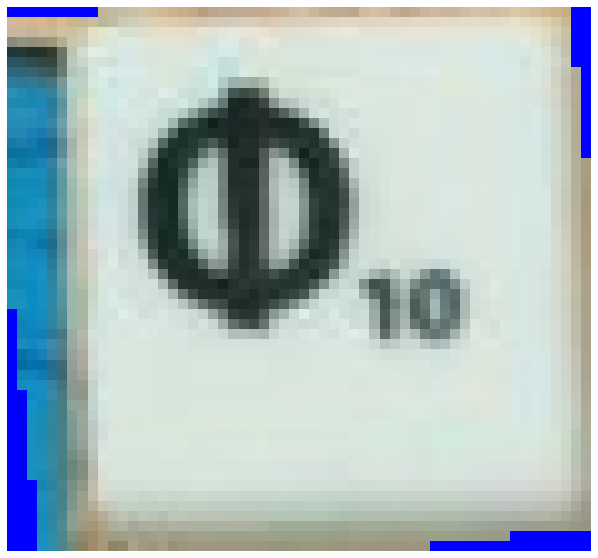

In [70]:
letters = []
for pic in pics:
  plot_img(pic[..., ::-1])
  p = predict_letter(pic)
  letters.append(p)

Letters on board

In [71]:
from scipy.spatial import distance

def board_letters(grid_coords, boxes_coords, letters):

  board = [[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], 
           [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], 
           [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], 
           [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], 
           [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], 
           [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], 
           [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], 
           [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], 
           [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], 
           [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], 
           [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], 
           [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], 
           [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], 
           [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], 
           [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]]

  for k in range(len(boxes_coords)):
    for i in range(len(grid_coords)):
      for j in range(len(grid_coords[0])):
        a = (grid_coords[i][j][0], grid_coords[i][j][1])
        b = (boxes_coords[k][0], boxes_coords[k][1])
        dst = distance.euclidean(a, b)
        if dst < 20:
          board[i][j] = letters[k]

  return board

In [72]:
board_letters(grid_coords, boxes_coords, letters)

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 'В', 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 'О', 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 'Р', 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 'Т', 0, 0, 0, 0, 0, 'З', 0, 0, 0, 0],
 [0, 0, 0, 'Б', 'Е', 'С', 'С', 'О', 'Н', 'Н', 'И', 'Ц', 'А', 0, 0],
 [0, 0, 0, 0, 'М', 0, 0, 0, 0, 0, 'М', 0, 0, 0, 0],
 [0, 0, 0, 0, 'И', 0, 0, 0, 0, 0, 'А', 0, 0, 0, 0],
 [0, 0, 0, 0, 'А', 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 'Н', 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 'О', 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]